# 检查生成的label文件

正在检查: 0524_161257_261876_365.bmp
Detected class ID: 0


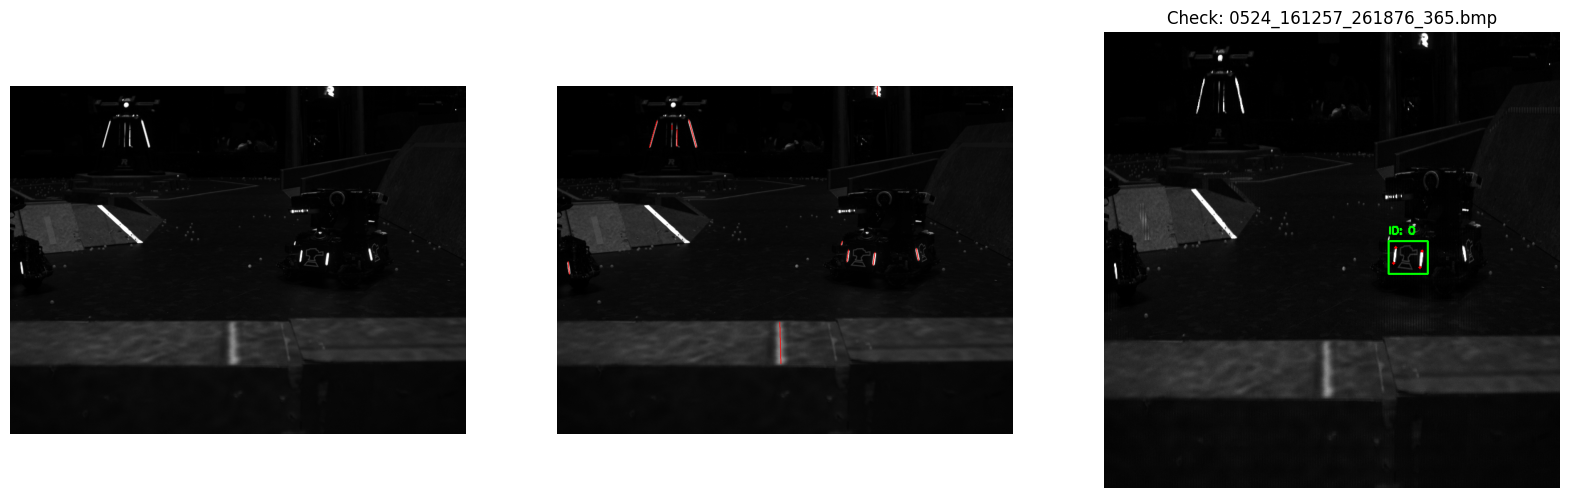

In [337]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from pathlib import Path

import sys
sys.path.append("..")  # 添加上级目录到路径，方便导入模块
from src.lable_generator import *

# ================= 配置路径 =================
# 将这里修改为你刚才生成的数据集路径
IMAGE_DIR = Path("/home/wangfeng/RM2026/amor_data/competation/5-24/3/images_0524_1608") 
LABEL_DIR = Path("/home/wangfeng/RM2026/amor_data/python_refactor/dataset/train/labels")
# ===========================================

class LightParams:
    """灯条筛选参数(参考C++代码)"""
    min_ratio = 0.01      # 最小宽长比
    max_ratio = 0.4      # 最大宽长比(从0.55降低到0.4,更严格)
    max_angle = 45       # 最大倾斜角度
    min_length = 10      # 最小长度(增加到10)
    min_width = 2        # 最小宽度

l_params = LightParams()

def preprocess_image(img):
    """图像预处理 - 二值化"""
    _, binary = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return binary

def find_lights(binary_img) -> List[Light]:
    """查找灯条"""
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    lights = []
    for contour in contours:
        if len(contour) < 5:       
            continue
        
        r_rect = cv2.minAreaRect(contour)
        light = Light(r_rect)

        if not is_light(light):
            continue
        lights.append(light)
    
    return lights
    
def is_light(light: Light) -> bool:
    """判断是否为有效灯条"""
    if light.length == 0:
        return False
    
    # 长宽比判断 - 灯条应该是细长的
    ratio = (light.width - 20) / light.length
    ratio_ok = l_params.min_ratio < (light.width / light.length) and ratio < l_params.max_ratio

    # 角度判断
    angle_ok = abs(light.angle) < l_params.max_angle

    # 尺寸判断 - 确保灯条足够长且有一定宽度
    size_ok = light.length >= l_params.min_length and light.width >= l_params.min_width

    return ratio_ok and angle_ok and size_ok


def visualize_yolo_pose(image_path, label_path):
    # ... (读取图片代码不变) ...
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    lights = find_lights(preprocess_image(img))


    vis_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # 2) 先画所有灯条
    for l in lights:
        p1 = tuple(map(int, l.top))
        p2 = tuple(map(int, l.bottom))
        cv2.line(vis_img, p1, p2, (0, 0, 255), 2)

    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (640, 640))
    h, w, _ = img.shape
    
    # ... (读取标签代码不变) ...
    if not os.path.exists(label_path):
        print(f"Error: Label file not found at {label_path}")
        return

    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # 去除空行
    lines = [l.strip() for l in lines if l.strip()]

    print(f"正在检查: {os.path.basename(image_path)}")
    
    # ================= 修改部分 =================
    if not lines:
        # 如果文件是空的，说明这是一张负样本背景图
        print(">>> 注意：该图片为【负样本/背景图】，没有标注目标。")
        cv2.putText(img, "Negative Sample (Background)", (50, h//2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    else:
        # 正常画框 (代码逻辑不变)
        for line in lines:
            data = list(map(float, line.split()))
            class_id = int(data[0])
            print(f"Detected class ID: {class_id}")
            
            # 如果你发现这里还有 class 6，说明生成代码没过滤干净
            if class_id == 6:
                print("Warning: 发现了未过滤的负样本 (ID 6)！")
            
            # ... (画框和画点的代码与之前一致) ...
            x_center, y_center, bbox_w, bbox_h = data[1:5]
            x1 = int((x_center - bbox_w / 2) * w)
            y1 = int((y_center - bbox_h / 2) * h)
            x2 = int((x_center + bbox_w / 2) * w)
            y2 = int((y_center + bbox_h / 2) * h)
            
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"ID: {class_id}", (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # 关键点绘制逻辑保持不变...
            keypoints = data[5:]
            num_kpts = len(keypoints) // 3
            for i in range(num_kpts):
                px = int(keypoints[i*3] * w)
                py = int(keypoints[i*3+1] * h)
                cv2.circle(img, (px, py), 2, (255, 0, 0), -1)

    # 显示
    plt.figure(figsize=(20, 12))

    plt.subplot(1, 3, 1)
    plt.imshow(img_)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Check: {os.path.basename(image_path)}")
    plt.show()

# ================= 随机抽取一张进行检查 =================
image_files = list(IMAGE_DIR.glob("*.jpg")) + list(IMAGE_DIR.glob("*.png")) + list(IMAGE_DIR.glob("*.bmp"))

if not image_files:
    print("未找到图片，请检查路径")
else:
    # 随机抽一张
    random_image = random.choice(image_files)
    # 对应的标签文件路径
    random_label = LABEL_DIR / (random_image.stem + ".txt")
    
    visualize_yolo_pose(random_image, random_label)

# 传统算法下灯条标注

In [160]:
import sys
import os
proj_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "../.."))

from src.lable_generator import *

def visualize_annotation(img, lights, armors):
    """
    可视化：
    - 所有灯条：灰色
    - 能组成装甲板的灯条：绿色
    - 装甲板关键点：黄色
    - 装甲板连线：青色
    """
    vis_img = img.copy()

    # 1) 收集所有“参与装甲板”的灯条 id（用对象 id 做标记，避免 Light 没有 unique_id）
    used_lights = set()
    for (l1, l2) in armors:
        used_lights.add(id(l1))
        used_lights.add(id(l2))

    # 2) 先画所有灯条
    for l in lights:
        p1 = tuple(map(int, l.top))
        p2 = tuple(map(int, l.bottom))
        cv2.line(vis_img, p1, p2, (0, 0, 255), 2)

    # 3) 再把“参与装甲板”的灯条覆盖画出来（绿色更醒目）
    for l in lights:
        if id(l) not in used_lights:
            continue
        p1 = tuple(map(int, l.top))
        p2 = tuple(map(int, l.bottom))
        cv2.line(vis_img, p1, p2, (0, 255, 0), 3)

    # 4) 画装甲板连线 + 关键点
    for (light_1, light_2) in armors:
        # # 确保 light_1 在左边
        # if light_1.center[0] > light_2.center[0]:
        #     light_1, light_2 = light_2, light_1

        # # 装甲板上下边（青色）
        # cv2.line(
        #     vis_img,
        #     tuple(map(int, light_1.top)),
        #     tuple(map(int, light_2.top)),
        #     (255, 255, 0),
        #     2,
        # )
        # cv2.line(
        #     vis_img,
        #     tuple(map(int, light_1.bottom)),
        #     tuple(map(int, light_2.bottom)),
        #     (255, 255, 0),
        #     2,
        # )

        # 关键点（黄色）
        keypoints = [light_1.top, light_1.bottom, light_2.bottom, light_2.top]
        for i, kp in enumerate(keypoints):
            cv2.circle(vis_img, tuple(map(int, kp)), 5, (0, 255, 255), -1)
            cv2.putText(
                vis_img,
                str(i),
                tuple(map(int, kp)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 255),
                1,
            )

    return vis_img

detector = TraditionalArmorDetector()

NameError: name '__file__' is not defined